In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
# Import loan.csv file in a pandas data frame. Kept type of "next_pymnt_d" as string as Python was complaining
# about mixed types of this column.
lender_data = pd.read_csv("loan.csv", dtype = {"next_pymnt_d": "string"})
lender_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
## Data cleaning

In [129]:
# First drop duplicate rows
lender_data.drop_duplicates()

# Then, drop columns with more than 75% of NA values
na_threshold = 75
min_non_na_count = int(((100-na_threshold)/100)*lender_data.shape[0] + 1)
lender_data.dropna(axis = 1, thresh = min_non_na_count, inplace=True)
print(lender_data.shape)

(39717, 55)


In [132]:
# Remove months from term column and change its type to int
lender_data["term"] = lender_data["term"].str.replace(" months", "")
lender_data = lender_data.astype({"term": "int32"})
lender_data["term"].head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int32

In [130]:
# Remove % from int_rate and change its type to float
lender_data["int_rate"] = lender_data["int_rate"].str.replace("%", "")
lender_data = lender_data.astype({"int_rate": "float32"})
lender_data["int_rate"].head()

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float32

## Univariate analysis

### Loan amount distribution

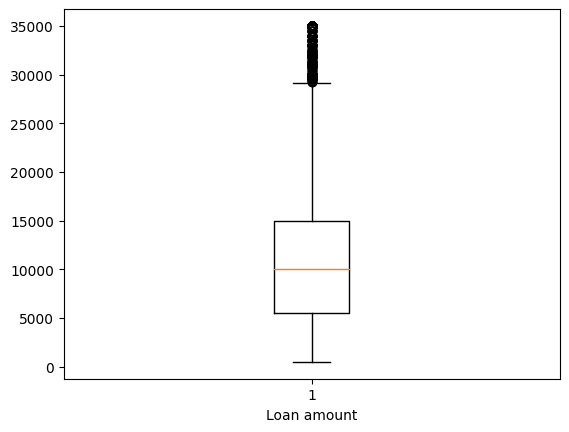

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [211]:
plt.boxplot(lender_data["loan_amnt"])
plt.xlabel("Loan amount")
plt.show()
lender_data["loan_amnt"].describe()

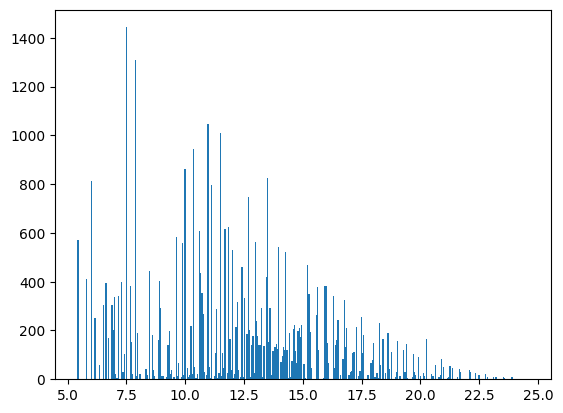

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64


In [212]:
# Effect of rate of interest on loan status
plt.hist(lender_data["int_rate"], bins = len(lender_data["int_rate"].unique()))
plt.show()
print(lender_data["int_rate"].describe())

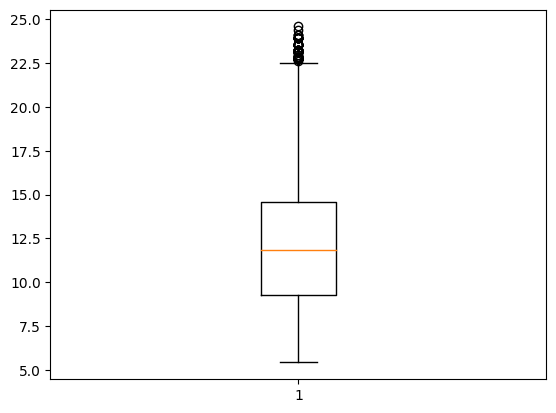

In [210]:
plt.boxplot(lender_data["int_rate"])
plt.show()

### Insights
1. 50% of the loans lie in the range [5500, 15000].
2. Median loan amount is Rs. 10000.
3. 25% of loan amounts lie in the range [15000, 35000].
4. Around 1400 customers have an interest rate of 7.5%.
5. 50% of customers have interest rate between 9% to 14%.

## Segmented Analysis

term
36    29096
60    10621
dtype: int64


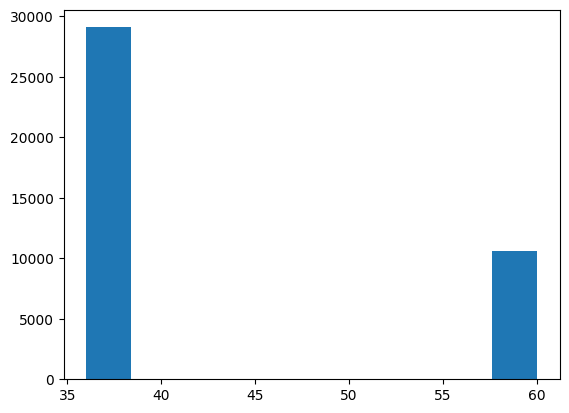

In [139]:
# Grouping on interest time period
grouped_on_term = lender_data.groupby("term").size()
print(grouped_on_term)
plt.hist(lender_data["term"])
plt.show()

In [241]:
# Grouping on interest time period and loan status
grouped_on_term_and_loan_status = lender_data.groupby(["term", "loan_status"]).size()
x = grouped_on_term_and_loan_status.index.tolist()
y = grouped_on_term_and_loan_status.values.tolist()
print("Percentage of customers with 36 months of interest term that have defaulted", int(grouped_on_term_and_loan_status[(36, 'Charged Off')] / grouped_on_term[36] * 100))
print("Percentage of customers with 60 months of interest term that have defaulted", int(grouped_on_term_and_loan_status[(60, 'Charged Off')] / grouped_on_term[60] * 100))

Percentage of customers with 36 months of interest term that have defaulted 11
Percentage of customers with 60 months of interest term that have defaulted 22


### Analysis by grouping on term and loan status

1. Among customers having 60 months of interest term, 22% default their loans.
2. Among customers having 36 months of interest term, 11% default their loans.

So, people with higher interest time period have a higher tendency to default their loans.

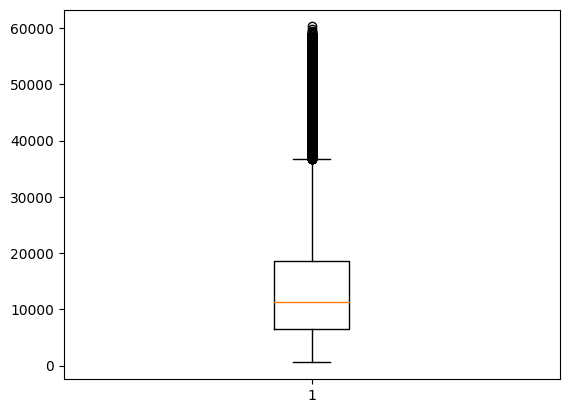

count    39717.00000
mean     13993.52591
std      10119.26240
min        564.84000
25%       6528.60000
50%      11379.96000
75%      18627.12000
max      60303.60000
Name: principal_amnt, dtype: float64

In [218]:
# Lets derive a new metric principal amount from installment and term for simplicity.
# It can also be derived from loan amount, interest rate and term but that is difficult as that will compound interest formula.
lender_data["principal_amnt"] = (lender_data["installment"] * lender_data["term"]).round(2)
plt.boxplot(lender_data["principal_amnt"])
plt.show()
lender_data["principal_amnt"].describe()

In [234]:
def q75(x):
    return x.quantile(0.75)
def q25(x):
    return x.quantile(0.25)

In [236]:
# Now lets group the data on loan status and find the mean, median, mode principal amount in each segment
grouped_on_loan_status = lender_data.groupby("loan_status")
principal_amount_aggregation = grouped_on_loan_status.agg({"principal_amnt": [pd.Series.mean, pd.Series.median, pd.Series.mode, pd.Series.max, pd.Series.min, q25, q75]})
print(grouped_on_loan_status["principal_amnt"].count())
principal_amount_aggregation

loan_status
Charged Off     5627
Current         1140
Fully Paid     32950
Name: principal_amnt, dtype: int64


principal_amnt                                                  \
                      mean    median      mode      max      min       q25   
loan_status                                                                  
Charged Off   15889.188868  12621.00  16563.60  60303.6  1049.76   6982.20   
Current       23728.563684  22091.40  16563.60  58887.0  1304.40  15508.20   
Fully Paid    13332.984528  11062.08  11199.96  59466.0   564.84   6315.03   

                      
                 q75  
loan_status           
Charged Off  22121.4  
Current      31183.5  
Fully Paid   17746.2

### Analysis by grouping on loan status and aggregating principal amount metric
Among the 5627 customers that have defaulted:
1. 25% customers have principal amount less than ₹ 7000 approximately.
2. 50% customers have principal amount between ₹ 7000 and ₹ 22000.
3. 25% customers have principal amount above ₹ 22000 highest being close to ₹ 60000.

This proves the pattern that customers with high principal amount are more likely to default their loans.

In [243]:
# Lets group the data on loan repayment status and customer's annual income
annual_income_aggregation = grouped_on_loan_status.agg({"annual_inc": [pd.Series.mean, pd.Series.median, pd.Series.mode, pd.Series.max, pd.Series.min, q25, q75]})
annual_income_aggregation

annual_inc                                                 \
                     mean   median     mode        max     min       q25   
loan_status                                                                
Charged Off  62427.298034  53000.0  60000.0  1250000.0  4080.0  37000.00   
Current      75430.665105  65000.0  60000.0   650000.0  9960.0  47475.00   
Fully Paid   69862.503328  60000.0  60000.0  6000000.0  4000.0  41132.75   

                      
                 q75  
loan_status           
Charged Off  75000.0  
Current      90000.0  
Fully Paid   84000.0

### Analysis by grouping on loan status and aggregating principal amount metric
1. The mean and median income of defauled customers is the lowest.
2. The inter quartile range of annual income of defaulted customers is also the lowest among all.

So, customers having an annual income less than ₹ 75000 are more likely to default their loans.

[36.45 25.48 38.07]


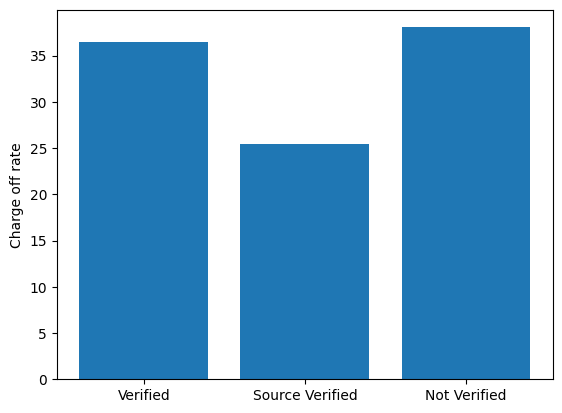

In [267]:
# Lets analyse verification status and loan status
grouped_on_verification_and_loan_status = lender_data.groupby(["verification_status", "loan_status"]).size()
verification_keys = lender_data["verification_status"].unique()
verification_values = np.array([grouped_on_verification_and_loan_status[('Verified', 'Charged Off')], grouped_on_verification_and_loan_status[('Source Verified', 'Charged Off')], grouped_on_verification_and_loan_status[('Not Verified', 'Charged Off')]])
verification_values = (verification_values / 5627 * 100).round(2)
print(verification_values)
plt.bar(verification_keys, verification_values)
plt.ylabel("Charge off rate")
plt.show()

### Analysis by grouping on verification status and loan status
1. There isn't a direct correlation between the income verification status and loan default rate.
2. This is due to the fact that charge off rate is the roughly the same for loans that were verified and unverified loans.
3. This raises the question on the bank's should income verification process. It probably needs an improvement.
4. Charge off rate is lower for customers whose income source was verified. This might mean that these customers are working in a legitimate company and have correctly reported their income.
5. This might also mean that not all verified income customers have reported their income honestly. They might have a business of their own due to which they are able to do so.